In [219]:
import pyart
import numpy as np
import nexradaws
import tempfile
import xarray as xr
import time
import warnings
from netCDF4 import Dataset
import datetime

warnings.filterwarnings("ignore")

In [220]:
# Central lat/lon of ARM SGP site 
site_latlon = [36.607322, -97.487643]

In [221]:
# Create temp file, connect to NEXRAD AWS, request files by date & station ID
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans(2019, 8, 22, 'KVNX') #scans = conn.get_avail_scans(2019, 11, 10, 'KVNX')

In [222]:
# Download selected volume scans
num_scans = scans[100:103]
localfiles = conn.download(num_scans, templocation)

Downloaded KVNX20190822_085122_V06
Downloaded KVNX20190822_084514_V06
Downloaded KVNX20190822_085730_V06
3 out of 3 files downloaded...0 errors


In [223]:
sweep = np.arange(0,18)

gate_lat_site = np.nan*np.ma.ones((3, 18))
gate_lon_site = np.nan*np.ma.ones((3, 18))
gate_alt_site = np.nan*np.ma.ones((3, 18))
Z_site = np.nan*np.ma.ones((3, 18))
scan_times = []
j = 0 

# Loop through the volume scans
for scan in localfiles.iter_success():
    
    # Read in the volume scans, get the times of the scans
    radar = pyart.io.read(localfiles.success[j].filepath)
    volume_scan_t = scan.scan_time
    scan_times.append(volume_scan_t)
    print(j)
    
    # Loop through all the sweeps in a volume scan
    for i in range(radar.nsweeps):
        slice_start, slice_end = radar.get_start_end(i)
        gate_longitude = radar.gate_longitude['data'][slice_start:slice_end,:]
        gate_latitude = radar.gate_latitude['data'][slice_start:slice_end,:]
        gate_altitude = radar.gate_altitude['data'][slice_start:slice_end,:]

        # Find the gate closest to the desired site 
        # Get the lat,lon,alt,ref of the gate closest to the desired site
        dist = np.sqrt(((gate_latitude - site_latlon[0])**2) + ((gate_longitude - site_latlon[1])**2))
        index = np.where(dist == dist.min())
        gate_lat_site[j,i] = gate_latitude[index[0][0], index[1][0]]
        gate_lon_site[j,i] = gate_longitude[index[0][0], index[1][0]]
        gate_alt_site[j,i] = gate_altitude[index[0][0], index[1][0]]
        Z_site[j,i] = radar.fields['reflectivity']['data'][slice_start+index[0][0], index[1][0]]

    print(volume_scan_t)
    print(Z_site)

    if j < 2:
        j += 1
        del radar
    else:
        print('done')
        print(scan_times)

0
2019-08-22 08:45:14+00:00
[[37.0 34.0 40.5 42.0 44.5 43.0 40.0 43.5 48.0 36.5 29.5 33.5 23.5 18.5
  2.5 -- -- --]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
1
2019-08-22 08:51:22+00:00
[[37.0 34.0 40.5 42.0 44.5 43.0 40.0 43.5 48.0 36.5 29.5 33.5 23.5 18.5
  2.5 -- -- --]
 [44.5 44.5 39.5 36.0 26.5 31.0 39.0 36.5 42.5 36.5 28.0 28.5 27.0 22.5
  7.0 -- -- --]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
2
2019-08-22 08:57:30+00:00
[[37.0 34.0 40.5 42.0 44.5 43.0 40.0 43.5 48.0 36.5 29.5 33.5 23.5 18.5
  2.5 -- -- --]
 [44.5 44.5 39.5 36.0 26.5 31.0 39.0 36.5 42.5 36.5 28.0 28.5 27.0 22.5
  7.0 -- -- --]
 [28.0 31.5 36.5 36.5 42.5 39.5 46.0 43.0 42.0 40.5 33.5 33.5 26.0 17.5
  6.5 -- -- --]]
done
[datetime.datetime(2019, 8, 22, 8, 45, 14, tzinfo=<UTC>), datetime.datetime(2019, 8, 22, 8, 51, 22, tzinfo=<UTC>), datetime.datetime(2019, 8, 22, 8, 57, 30

In [224]:
# Create an xarray dataset with dimensions time and sweep
ds = xr.Dataset({'Z_site': (['time','sweep'], Z_site),
            'gate_lat_site': (['time','sweep'], gate_lat_site),
            'gate_lon_site': (['time','sweep'], gate_lon_site),
            'gate_height': (['time','sweep'], gate_alt_site),
            },
            coords={'time': scan_times,'sweep': sweep})

ds

<xarray.Dataset>
Dimensions:        (sweep: 18, time: 3)
Coordinates:
  * time           (time) object 2019-08-22T08:45:14+00:00 ... 2019-08-22T08:...
  * sweep          (sweep) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Data variables:
    Z_site         (time, sweep) float64 37.0 34.0 40.5 42.0 ... 6.5 nan nan nan
    gate_lat_site  (time, sweep) float64 36.61 36.61 36.61 ... 36.61 36.61 36.61
    gate_lon_site  (time, sweep) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    gate_height    (time, sweep) float64 1.083e+03 1.083e+03 ... 2.146e+04

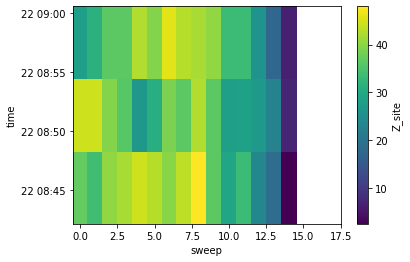

In [225]:
ds.Z_site.plot()